<div align="center">
    <h1>Υπολογιστική Γεωμετρία (1η Εργασία)</h1>
</div>

### **Ρυθμίσεις Γραφικών**
Παρακάτω ορίσουμε μερικές ρυθμίσεις οι οποίες θα φέρουν μία **καλύτερη οπτικοποίηση** των αποτελεσμάτων που θα εξάγουμε στην συνέχεια. Κάποιες από αυτές μπορείτε και να **επεξεργαστείτε**, και να τις διαμορφώσετε ανάλογα με τις προτιμήσεις σας.

In [80]:
from matplotlib import pyplot as plt

# Change this according to your theme. 
# For dark theme use 'dark_background'
# For light theme use 'default'
plots_theme = "dark_background"

plt.style.use(plots_theme)
grid_color = "#373737" if plots_theme == 'dark_background' else "#CDCDCD"

### Ορισμός Σημείου (Point Definition)
Θα ξεκινήσουμε την υλοποίησή μας ορίζοντας τη **γενική κλάση** που θα αναπαριστά ένα **σημείο** στο $\mathbb{R}^2$ με συντεταγμένες $x$ και $y$.

In [81]:
class Vector2D:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

    def __repr__(self):
        return f"({self.x:.3f}, {self.y:.3f})"


### Ορισμός Κυρτού Περιβλήματος (Convex Hull Definition)
Θα συνεχίσουμε ορίζοντας τη **κλάση** η οποία θα αναπαριστά ένα **κυρτό περίβλημα**, το οποίο θα αποτελείται από **σημεία** στον $\mathbb{R}^2$ χώρο, καθώς και **ακμές** οι οποίες θα υποδηλώνουν τις άκρες του περιβλήματος.

In [82]:
import numpy as np
from matplotlib import pyplot as plt

class Convex_Hull:
  def __init__(self, points: np.ndarray[Vector2D], hull_points: np.ndarray[Vector2D]):
    self.points = points
    self.hull_points = hull_points
    self.edges = self.__construct_edges(hull_points)

  def __construct_edges(self, hull_points: np.ndarray[Vector2D]):
    """ Constructs the edges list of the convex hull. """
    edges = []

    for i in range(len(hull_points) - 1):
        edges.append((hull_points[i], hull_points[i + 1]))
    edges.append((hull_points[-1], hull_points[0]))

    return edges

  def __repr__(self):
    return f"Convex_Hull\n-points={self.points}\n-edges={self.edges}"

  def __eq__(self, other):
    """ Checks whether two convex hulls are the same. """
    points_equality: bool = self.points == other.points
    hull_points_equality: bool = self.hull_points == other.hull_points
    edges_equality: bool = self.edges == other.edges
    
    return points_equality and hull_points_equality and edges_equality
  
  def plot(self, axes: plt.axes = None, title: str = ""):
    """
    Plots the convex hull. This function will plot the points and edges of the convex hull.
    """
    if axes is not None:
      axes.scatter([point.x for point in self.points], [point.y for point in self.points], color='#339AFF', s=10)

      # Plot the edges of the convex hull
      for edge in self.edges:
        axes.plot([edge[0].x, edge[1].x], [edge[0].y, edge[1].y], color='#FF6F6F')

      axes.grid(color=grid_color)
      axes.set_title(title)
    else:
      plt.scatter([point.x for point in self.points], [point.y for point in self.points], color='#339AFF', s=10)

      # Plot the edges of the convex hull
      for edge in self.edges:
        plt.plot([edge[0].x, edge[1].x], [edge[0].y, edge[1].y], color='#FF6F6F')

      plt.grid(color=grid_color)
      plt.title(title)
      plt.show()

### Ορισμός Γενικής Έννοιας του Αλγορίθμου Εύρεσης ΚΠ2
Στη συνέχεια θα ορίσουμε τη **γενική αφηρημένη κλάση** (abstract) του αλγορίθμου **εύρεσης** ενός **κυρτού περιβλήματος**. Κάθε αλγόριθμος που θα υλοποιήσουμε στη συνέχεια θα **κληρονομεί** αυτή την κλάση και δωσμένου ενός συνόλου από σημεία, θα υλοποιεί τη δικιά του μέθοδο εύρεσης του κυρτού περιβλήματος.

In [83]:
import numpy as np
from abc import ABC, abstractmethod


class ConvexHullSolutionAlgorithm(ABC):

  @abstractmethod
  def __call__(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
    ...


### Κατασκευή βοηθητικών συναρτήσεων
Πρωτού ασχοληθούμε με τον πρώτο αλγόριθμό μας, θα ορίσουμε μερικές συναρτήσεις οι οποίες θα μας βοηθήσουν με τη κατασκευή των αλγορίθμων μας. Συγκεκριμένα θα ορίσουμε μία συνάρτηση`are_collinear()` η οποία θα ελέγχει εάν **3 σημεία** στον $\mathbb{R}^2$  είναι **συνευθειακά**, καθώς και άλλη μία συνάρτηση `is_between()` η οποία θα ελέγχει εάν ένα σημείο είναι **ανάμεσα** από άλλα δύο. 

Επομένως ο συνδιασμός των συναρτήσεων `are_collinear()` και `is_between()` θα μας δείχνει εάν ένα σημείο είναι **εσωτερικό σημείο** του ευθυγράμμου τμήματος που ορίσουν δύο άλλα σημεία. 

Επίσης θα ορίσουμε δύο συναρτήσεις `CCW()` και `CW()` οι οποίες θα μας βοηθήσουν με **κατηγορήματα προσανατολισμού** και θα δείχνουν εάν 3 σημεία ορίζουν **θετική** ή **αρνητική** στροφή.

In [84]:
def are_collinear(p1: Vector2D, p2: Vector2D, p3: Vector2D) -> bool:
    # Check for vertical line to avoid division by zero
    if p2.x - p1.x == 0 or p3.x - p2.x == 0:
        return p2.x - p1.x == p3.x - p2.x
    
    # Calculate slopes
    slope1 = (p2.y - p1.y) / (p2.x - p1.x)
    slope2 = (p3.y - p2.y) / (p3.x - p2.x)
    
    return slope1 == slope2

def is_between(p2: Vector2D, p1: Vector2D, p3: Vector2D) -> bool:
    """ Checks whether p1, p2 and p3 are collinear and p2 is between p1 and p3. """
    return (
        min(p1.x, p3.x) <= p2.x <= max(p1.x, p3.x) and
        min(p1.y, p3.y) <= p2.y <= max(p1.y, p3.y)
    )

def CCW(p1: Vector2D, p2: Vector2D, p3: Vector2D) -> bool:
    # Define the supporting matrix for the three points to determine the orientation of the points
    matrix: np.ndarray[np.ndarray[float]] = np.array([
      [1, p1.x, p1.y], 
      [1, p2.x, p2.y], 
      [1, p3.x, p3.y]
    ])
    return np.linalg.det(matrix)


### Ορισμός Αυξητικού Αλγορίθμου (Graham's Scan Algorithm)
Θα ξεκινήσουμε ορίζοντας τον πρώτο μας αλγόριθμο, ο οποίος είναι ο **Ααυξητικός Αλγόριθμος** (Graham's Scan Algorithm). Ο αλγόριθμος αναπαριστάται με μία κλάση όπως φαίνεται παρακάτω όπου μπορεί κάποιος να τον καλέσει χρησιμοποιώντας τη μέθοδο `__call__()`.

In [85]:
import numpy as np

class GrahamScanAlgorithm(ConvexHullSolutionAlgorithm):
  def __construct_upper_hull(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
    L_upper: np.ndarray[Vector2D] = [points[0], points[1]]

    # Construct the upper hull of the convex hull
    for i in range(2, len(points)):
      L_upper.append(points[i])
      while len(L_upper) > 2 and not CCW(L_upper[-3], L_upper[-2], L_upper[-1]) < 0:
        L_upper.pop(-2)

    return L_upper
  
  def __construct_lower_hull(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
    L_lower: np.ndarray[Vector2D] = [points[-1], points[-2]]

    # Construct the lower hull of the convex hull
    for i in range(len(points) - 3, -1, -1):
      L_lower.append(points[i])
      while len(L_lower) > 2 and not CCW(L_lower[-3], L_lower[-2], L_lower[-1]) < 0:
        L_lower.pop(-2)

    # Remove the first and last points from L_lower to avoid duplication
    L_lower.pop(0)
    L_lower.pop(-1)

    return L_lower

  def __call__(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
    # Sort the points by their x-coordinate, then by their y-coordinate, and insert p1 and p2 to the L_upper set
    points: np.ndarray[Vector2D] = sorted(points, key=lambda p: (p.x, p.y))
    
    # Construct the upper and lower hulls of the convex hull
    L_upper: np.ndarray[Vector2D] = self.__construct_upper_hull(points)
    L_lower: np.ndarray[Vector2D] = self.__construct_lower_hull(points)

    # Merge the L_upper and L_lower sets to form the convex hull and return the result
    L: np.ndarray[Vector2D] = L_upper + L_lower

    return L

### Δοκιμή Αλγορίθμου
Ας δοκιμάσουμε τον αλγόριθμό. Για αρχή θα αρχικοποιήσουμε ένα σύνολο με **100 τυχαία** σημεία στο $\mathbb{R}^2$ χώρο. θα δημιουργήσουμε **δύο** σύνολα δεδομένων. Το ένα σύνολο θα περιέχει τυχαία δεδομένα όπου το χωρίο που θα καταλαμβάνουν χώρο με **ορθογωνιακό** σχήμα, και το δεύτερο σύνολο θα περιέχει δεδομένα τα οποία θα καταλαμβάνουν χώρο με **κυκλικό** σχήμα.

In [86]:
import numpy as np

POINTS_COUNT = 100

# Generate the rectangle set containing the random points
rectangle_points_set: np.ndarray[Vector2D] = []
for i in range(POINTS_COUNT):
  random_point = Vector2D(x=np.random.sample(), y=np.random.sample())
  rectangle_points_set.append(random_point)

# Generate the circular set containing the random points
circular_points_set: np.ndarray[Vector2D] = []
for i in range(POINTS_COUNT):
  angle = np.random.uniform(0, 2 * np.pi)
  radius = np.random.uniform(0, 1)
  x, y = radius * np.cos(angle), radius * np.sin(angle)
  random_point = Vector2D(x, y)
  circular_points_set.append(Vector2D(x, y))


Για να καταλάβουμε καλύτερα αυτά τα σύνολα δεδομένων, ας τα **οπτικοποιήσουμε**.

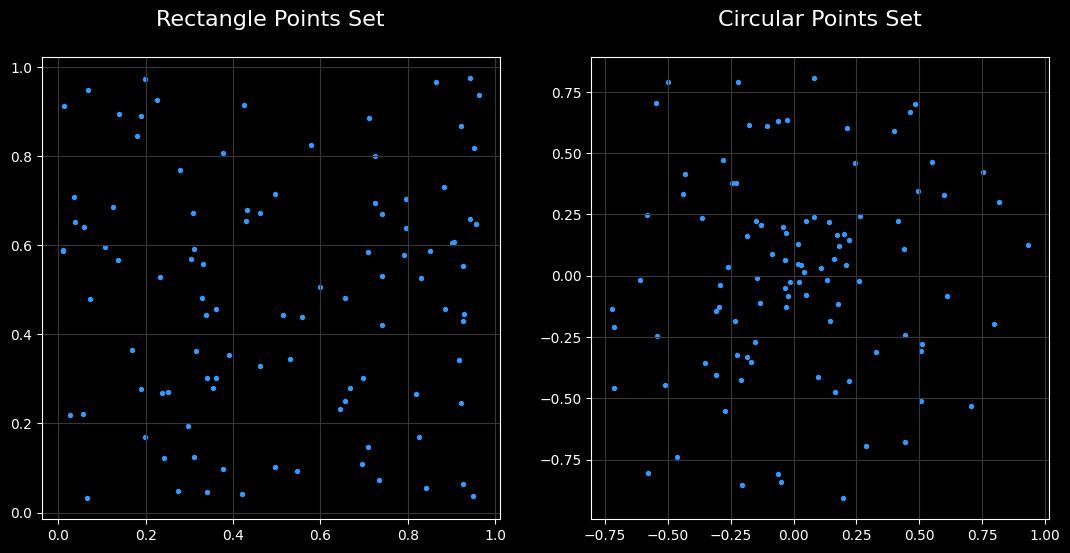

In [87]:
figure, axes = plt.subplots(1, 2, figsize=(13, 6))

for s_point, c_point in zip(rectangle_points_set, circular_points_set):
  axes[0].scatter(s_point.x, s_point.y, color='#339AFF', s=8)
  axes[1].scatter(c_point.x, c_point.y, color='#339AFF', s=8)

axes[0].set_title('Rectangle Points Set\n', fontsize=16)
axes[0].grid(color=grid_color)
axes[1].set_title('Circular Points Set\n', fontsize=16)
axes[1].grid(color=grid_color)

plt.show()

### Εύρεση του κυρτού περιβλήματος (Convex Hull Calculation)
Έχοντας δημιουργήσει τα σύνολα δεδομένων μας, ήρθε η ώρα να δοκιμάσουμε τον αλγόριθμό μας.

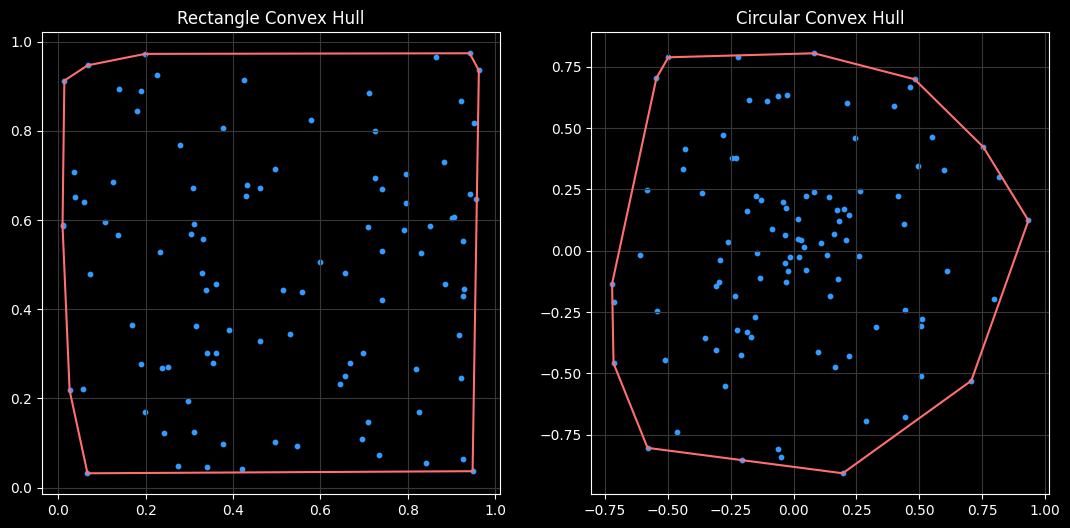

In [88]:
# Initialize the algorithm
gs_algorithm = GrahamScanAlgorithm()

# Compute the convex hull for the rectangle and the circular points set
rect_gs_result = gs_algorithm(np.array(rectangle_points_set))
circ_gs_result = gs_algorithm(np.array(circular_points_set))

# Create the convex hull objects
rect_convex_hull = Convex_Hull(rectangle_points_set, rect_gs_result)
circ_convex_hull = Convex_Hull(circular_points_set, circ_gs_result)

# Plot the convex hulls
figure, axes = plt.subplots(1, 2, figsize=(13, 6))
rect_convex_hull.plot(axes[0], title="Rectangle Convex Hull")
circ_convex_hull.plot(axes[1], title="Circular Convex Hull")

Όπως παρατηρούμε από τα παραπάνω διαγράμματα, ο αλγόριθμός μας λειτούργησε αποτελεσματικά για τα δύο σύνολα δεδομένων.

### Αλγόριθμος Περιτυλίγματος (Gift Wrapping)
Θα συνεχίσουμε υλοποιώντας τους υπόλοιπους αλγορίθμους, ξεκινώντας με τον **Αλγόριθμο Του Περιτυλίγματος** (Gift Wrapping Algorithm)

In [89]:
class GiftWrappingAlgorithm(ConvexHullSolutionAlgorithm):
    def __call__(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
        # Create a copy of the points array and compute the leftmost point
        S = points.copy()
        r0 = min(S, key=lambda p: (p.x, p.y))
        r = r0
        
        # Initialize the array containing the selcted points for the convex hull
        selected_points: np.ndarray[Vector2D] = [r]
        
        while True:
            # Let u be a point on the convex hull that has not been selected yet
            remaining_points: np.ndarray[Vector2D] = [p for p in S if p not in selected_points]
            u = remaining_points[0]
            
            # Check all the other points until we find the next prospective point for the hull points 
            for t in points:
                if CCW(r, u, t) > 0 or (are_collinear(r, u, t) and is_between(u, r, t)):
                    u = t
            
            # Check if the current point selected is the first point. If that is the case the process 
            # has been completed.
            # Otherwise we append the point on the hull points and remove it from our points array.
            if u == r0:
                return selected_points
            else:
                r = u
                S.remove(r)
                selected_points.append(r)


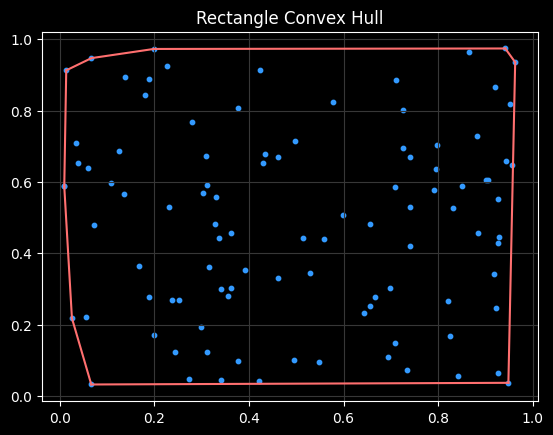

In [90]:
gw_algorithm = GiftWrappingAlgorithm()
result = gw_algorithm(rectangle_points_set)

# Create the convex hull object
convex_hull = Convex_Hull(rectangle_points_set, result)
convex_hull.plot(title="Rectangle Convex Hull")

### Αλγόριθμος Διαίρει και Βασίλευε (Devide and conquer)

In [91]:
from typing import Tuple

class DevideAndConquerAlgorithm(ConvexHullSolutionAlgorithm):
  def __find_upper_tangent(self, left: np.ndarray[Vector2D], right: np.ndarray[Vector2D]) -> Tuple[int, int]:
      left_idx, right_idx = len(left) - 1, 0
      while True:
          updated = False
          # Move the left index counter-clockwise
          while CCW(left[left_idx], left[left_idx - 1], right[right_idx]) < 0:
              left_idx = (left_idx - 1) % len(left)
              updated = True 
              
          # Move the right index clockwise
          while CCW(right[right_idx], right[(right_idx + 1) % len(right)], left[left_idx]) > 0:
              right_idx += 1
              updated = True  
              
          if not updated:
              break
      
      return left_idx, right_idx
      
  def __find_lower_tangent(self, left: np.ndarray[Vector2D], right: np.ndarray[Vector2D]) -> Tuple[int, int]:
      left_idx, right_idx = len(left) - 1, 0
      while True:
          updated = False
          # Move the left index clockwise
          while CCW(left[left_idx], left[left_idx - 1], right[right_idx]) > 0:
              left_idx = (left_idx - 1) % len(left)
              updated = True
          
          # Move the right index counter-clockwise
          while CCW(right[right_idx], right[(right_idx + 1) % len(right)], left[left_idx]) < 0:
              right_idx += 1
              updated = True
              
          if not updated:
              break
      
      return left_idx, right_idx
  
  def __merge(self, A: np.ndarray[Vector2D], B: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
    upper_tangent = self.__find_upper_tangent(A, B)
    lower_tangent = self.__find_lower_tangent(A, B)
    
    # # Combine the two hulls
    # merged_hull = []
    # idx = upper_tangent[0]
    # while idx != lower_tangent[0]:
    #     merged_hull.append(A[idx])
    #     idx = (idx + 1) % len(A)
    # merged_hull.append(A[lower_tangent[0]])
    
    # idx = lower_tangent[1]
    # while idx != upper_tangent[1]:
    #     merged_hull.append(B[idx])
    #     idx += 1
    # merged_hull.append(B[upper_tangent[1]])
    
    return [A[upper_tangent[0]], B[upper_tangent[1]], B[lower_tangent[1]], A[lower_tangent[0]]]
    
    
  def __call__(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
    # Sort the points by their x-coordinate
    points = sorted(points, key=lambda p: (p.x, p.y))
    
    if len(points) <= 3:
        return points
    
    # Divide the points into two sets
    left_points = points[:len(points) // 2]
    right_points = points[len(points) // 2:]
    
    L1 = self.__call__(left_points)
    L2 = self.__call__(right_points)
    
    return self.__merge(L1, L2)

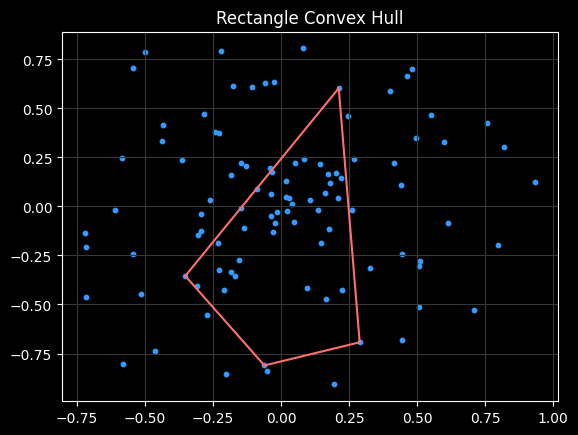

In [92]:
dq_algorithm = DevideAndConquerAlgorithm()
result = dq_algorithm(circular_points_set)

# Create the convex hull object
convex_hull = Convex_Hull(circular_points_set, result)
convex_hull.plot(title="Rectangle Convex Hull")


### Αλγόριθμος Quick Hull

In [93]:
class QuickHullAlgorithm(ConvexHullSolutionAlgorithm):
    def __get_distance(self, A: Vector2D, B: Vector2D, p: Vector2D) -> float:
        numerator = abs((B.y - A.y) * p.x - (B.x - A.x) * p.y + B.x * A.y - B.y * A.x)
        denominator = np.sqrt((B.y - A.y) ** 2 + (B.x - A.x) ** 2)
    
        return numerator / denominator
    
    def __find_hull(self, A: Vector2D, B: Vector2D, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
        if len(points) <= 1:
            return points
        
        # Find the point with maximum distance from the line AB
        C = max(points, key=lambda p: self.__get_distance(A, B, p))
        
        # Find the points on the left and right side of the line AC
        M = [p for p in points if CCW(A, C, p) > 0]
        N = [p for p in points if CCW(C, B, p) > 0]
        
        # Recursively find the hulls for the two sets of points
        L1 = self.__find_hull(A, C, M)
        L2 = self.__find_hull(C, B, N)
    
        return L1 + [C] + L2
        
    def __call__(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
        # Find the leftmost, rightmost, topmost and bottommost points
        leftmost, rightmost = min(points, key=lambda p: p.x), max(points, key=lambda p: p.x)
        topmost, bottommost = max(points, key=lambda p: p.y), min(points, key=lambda p: p.y)
        
        # Find the points on the left and right side of the line determined by the leftmost and rightmost points
        L1 = self.__find_hull(bottommost, leftmost, [p for p in points if CCW(bottommost, leftmost, p) > 0])
        L2 = self.__find_hull(leftmost, topmost, [p for p in points if CCW(leftmost, topmost, p) > 0])
        
        # Find the points on the left and right side of the line determined by the topmost and rightmost points
        L3 = self.__find_hull(topmost, rightmost, [p for p in points if CCW(topmost, rightmost, p) > 0])
        L4 = self.__find_hull(rightmost, bottommost, [p for p in points if CCW(rightmost, bottommost, p) > 0])
        
        return [bottommost] + L1 + [leftmost] + L2 + [topmost] + L3 + [rightmost] + L4

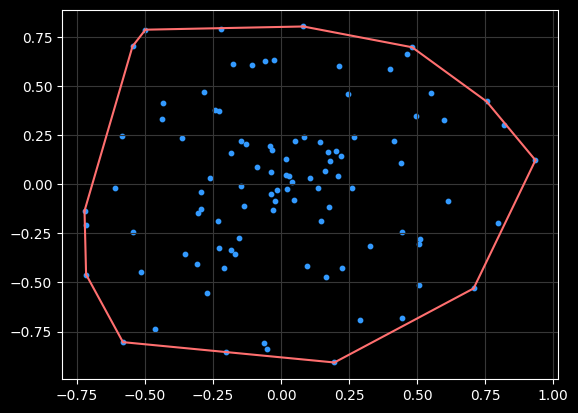

In [94]:
qh_algorithm = QuickHullAlgorithm()
result = qh_algorithm(circular_points_set)

hull = Convex_Hull(circular_points_set, result)
hull.plot()


### Σύγκριση αλγορίθμων ως προς το χρόνο

Στη συνέχεια θα συγκρίνουμε τους παραπάνω αλγορίθμους ως προς το χρόνο υλοποίησής τους. Συγκεκριμένα θα ορίσουμε διάφορα πλήθη σημείων στο επίπεδο $\mathbb{R}^2$ και θα παρουσιάσουμε τους χρόνους τους σε διαγράμματα.

In [95]:
# Define a variaty of datasets
datasets = []
points_counts = [i for i in range(100, 1100, 100)]

for i in range(len(points_counts)):
    dataset: np.ndarray[Vector2D] = []
    for i in range(points_counts[i]):
      random_point = Vector2D(x=np.random.sample(), y=np.random.sample())
      dataset.append(random_point)
        
    datasets.append(dataset)

In [96]:
import time

algorithms = [gs_algorithm, gw_algorithm, dq_algorithm, qh_algorithm]
algo_times = []

# Run every algorithm to the datasets and measure their time
for algorithm in algorithms:
    times = []
    for dataset in datasets:
        start_time = time.time()
        algorithm(dataset)
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        times.append(elapsed_time)
    
    algo_times.append(times)

Ας προβάλουμε τα αποτελέσματα σε ένα διάγραμμα.

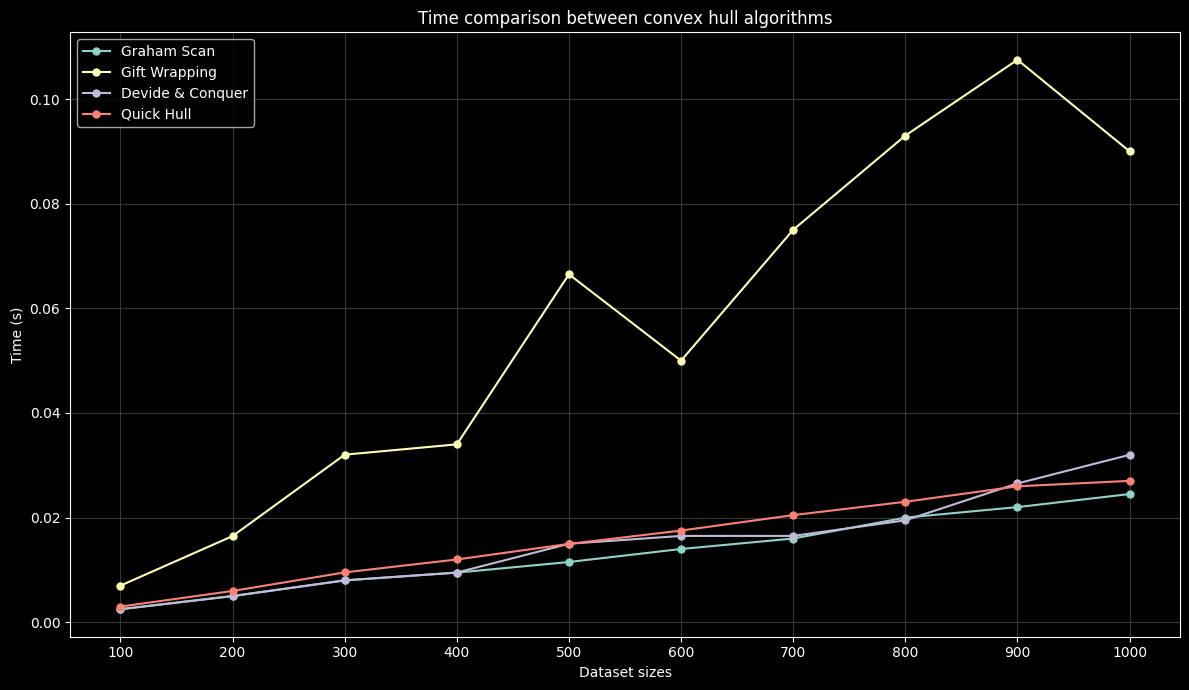

In [97]:
from matplotlib import pyplot as plt

algorithms_names = ['Graham Scan', 'Gift Wrapping', 'Devide & Conquer', 'Quick Hull']

figure, axes = plt.subplots(figsize=(12, 7))
for i in range(len(algorithms)):
    axes.plot(algo_times[i], marker='o', markersize=5, label=algorithms_names[i])
    
plt.title('Time comparison between convex hull algorithms')
plt.xlabel('Dataset sizes')
plt.ylabel('Time (s)')

plt.grid(color=grid_color)
plt.xticks([i for i in range(len(points_counts))], [str(i) for i in points_counts])
           
plt.legend()
plt.tight_layout()
plt.show()

Όπως παρατηρούμε από το παραπάνω διάγραμμαοι αλγόριθμοι **Graham Scan**, **Devide & Conquer** και **Quick Hull** φαίνεται να έχουν λίγο πολύ τον ίδιο χρόνο υλοποίησης του κυρτού περιβλήματος. Τη διαφορά κάνει ο αλγόριθμος **Gift Wrapping** που φαίνεται να παίρνει πολύ περισσότερο από τους άλλους δύο. Αυτο φυσικά θα εξηγεί και την πολυπλοκότητα αυτών των αλγορίθμων. 

## Κατασκευή Αυξητικού Αλγορίθμου στον 3D χώρο
Στη συνέχεια θα κατασκευάσουμε μία έκδοση του **αυξητικού αλγορίθμου** η οποία θα κατασκευάζει το κυρτό περίβλημα ενός συνόλου από σημεία, τα οποία ανήκουν στον **τρισδιάστατο χώρο $\mathbb{R}^3$**.

### Δημιουργία συνόλου δεδομένων
Αρχικά θα δημιουργήσουμε ένα σετ δεδομένων από σημεία στο **τρισδιάτατο χώρο**. Θα ορίσουμε αρχικά τη κλάση του σημείου.

In [98]:
class Vector3D:
    def __init__(self, x: float, y: float, z: float):
        self.x = x
        self.y = y
        self.z = z

    def __repr__(self):
        return f"({self.x:.3f}, {self.y:.3f}, {self.z:.3f})"

Στη συνέχεια θα δημιουργήσουμε ένα σετ δεδομένων με **80 σημεία** στο 3D χώρο.

In [99]:
import numpy as np

dataset: np.ndarray[Vector3D] = []
for i in range(80):
    random_point = Vector3D(x=np.random.sample(), y=np.random.sample(), z=np.random.sample())
    dataset.append(random_point)

### Κατασκευή αλγορίθμου

Αρχικά θα φροντίσουμε να παρέχουμε το **κατηγόρημα CCW** σε 3 διαστάσεις, καθώς θα μας φανεί χρήσιμο για την εύρεση του κυρτού περιβλήματος στο 3D χώρο.

In [100]:
def CCW_3D(p1: Vector3D, p2: Vector3D, p3: Vector3D, p4: Vector3D) -> float:
    # Define the supporting matrix for the three points to determine the orientation of the points
    matrix: np.ndarray[np.ndarray[float]] = np.array([
      [1, p1.x, p1.y, p1.z], 
      [1, p2.x, p2.y, p2.z], 
      [1, p3.x, p3.y, p3.z],
      [1, p4.x, p4.y, p4.z]
    ])
    return np.linalg.det(matrix)

Στη συνέχεια θα ορίσουμε κάποιες βοηθητικές δομές για τον αλγόριθμο. Συγκεκριμένα θα ορίσουμε δομές για τις **ακμές** (edges), για τις **όψεις** (faces) και για τα **πολύεδρα** (polyhedrons) που θα προκύψουν.

In [101]:
class Edge:
    def __init__(self, v1: Vector3D, v2: Vector3D):
        self.v1 = v1
        self.v2 = v2
        self.vertices = [v1, v2]
        
    def __eq__(self, other):
        return (self.v1 == other.v1 and self.v2 == other.v2) or (self.v1 == other.v2 and self.v2 == other.v1)
        
    def __repr__(self):
        return f"Edge({self.v1}, {self.v2})"

class Face:
  def __init__(self, v1: Vector3D, v2: Vector3D, v3: Vector3D):
    self.v1 = v1
    self.v2 = v2
    self.v3 = v3
    self.edges = [Edge(v1, v2), Edge(v2, v3), Edge(v3, v1)]
    
  def get_vertices(self):
    return [
      (self.v1.x, self.v1.y, self.v1.z),
      (self.v2.x, self.v2.y, self.v2.z),
      (self.v3.x, self.v3.y, self.v3.z)
    ]
    
  def __repr__(self):
    return f"Face({self.v1}, {self.v2}, {self.v3})"
  
class Polyhedron:
  def __init__(self, faces: np.ndarray[Face]):
    self.faces = faces
    
  def __repr__(self):
    return f"Polyhedron({self.faces})"

Τέλος ας κατασκευάσουμε τον αλγόριθμο για τις 3 διαστάσεις.

In [102]:
class BeneathBeyond3DAlgorithm(ConvexHullSolutionAlgorithm):
  def __get_red_faces(self, polyhedron: Polyhedron, current_point: Vector3D) -> np.ndarray[Face]:
    red_faces = []
    
    # Find all the red faces of the polyhedron
    for face in polyhedron.faces:
      
      # Find the other vertex of the face that is not in the current face
      for other_face in polyhedron.faces:
        if other_face != face:
          for vertex in [other_face.v1, other_face.v2, other_face.v3]:
            if vertex not in [face.v1, face.v2, face.v3]:
              other_vertex = vertex

      # Detenrmine the orientation of the current point with respect to the face
      first_ccw = CCW_3D(face.v1, face.v2, face.v3, other_vertex)
      second_ccw = CCW_3D(face.v1, face.v2, face.v3, current_point)

      # Check if the two ccw results have different signs and add the face to the red faces
      if first_ccw * second_ccw < 0:
        red_faces.append(face)
        
    return red_faces
  
  def __get_blue_faces(self, polyhedron: Polyhedron, red_faces: np.ndarray[Face]) -> np.ndarray[Face]:
    blue_faces = []
    
    # Find the blue faces of the polyhedron and return them
    for face in polyhedron.faces:
      if face not in red_faces:
        blue_faces.append(face)
        
    return blue_faces
  
  def __get_purple_edges(self, blue_faces: np.ndarray[Face], red_faces: np.ndarray[Face]) -> np.ndarray[Edge]:
    purple_edges = []
    
    # Find all the purple edges of the polyhedron and return them 
    for blue_face in blue_faces:
      for edge in blue_face.edges:       
        for red_face in red_faces:
          if edge in red_face.edges:
            if edge not in purple_edges:
              purple_edges.append(edge)
              
    return purple_edges
  
  
  def __add_points_to_hull(self, polyhedron: Polyhedron, points: np.ndarray[Vector3D]) -> Polyhedron:
    # Add the remaining points to the polyhedron
    for k in range(4, len(points)):  
      
      # Find the red and blue faces of the polyhedron
      red_faces = self.__get_red_faces(polyhedron, points[k])
      blue_faces = self.__get_blue_faces(polyhedron, red_faces)
      
      # Find the purple edges of the polyhedron
      purple_edges = self.__get_purple_edges(blue_faces, red_faces)
      
      # Remove the red faces from the polyhedron
      for face in red_faces:
        polyhedron.faces.remove(face)
        
      # Add the new faces to the polyhedron that are formed by the purple edges and the new point
      for edge in purple_edges:
        polyhedron.faces.append(Face(edge.v1, edge.v2, points[k]))
    
  def __call__(self, points: np.ndarray[Vector3D]) -> np.ndarray[Vector3D]:
    # Sort the points by descending order of x-coordinate
    points = sorted(points, key=lambda p: (p.x, p.y, p.z))
    
    # Initialize the first polyhedron
    polyhedron = Polyhedron([
      Face(points[0], points[1], points[2]),
      Face(points[0], points[1], points[3]),
      Face(points[0], points[2], points[3]),
      Face(points[1], points[2], points[3])
    ])
    
    # Add the rest of the points to the polyhedron if there are any
    self.__add_points_to_hull(polyhedron, points)
        
      
    return polyhedron.faces

Ας δοκιμάσουμε τον αλγόριθμο για το σετ δεδομένων που ορίσαμε παραπάνω.

In [103]:
bb3d_algorithm = BeneathBeyond3DAlgorithm()
result = bb3d_algorithm(dataset)

Ας οπτικοποιήσουμε το κυρτό περίβλημα που προέκυψε από την παραπάνω εκτέλεση του αλγορίθμου.

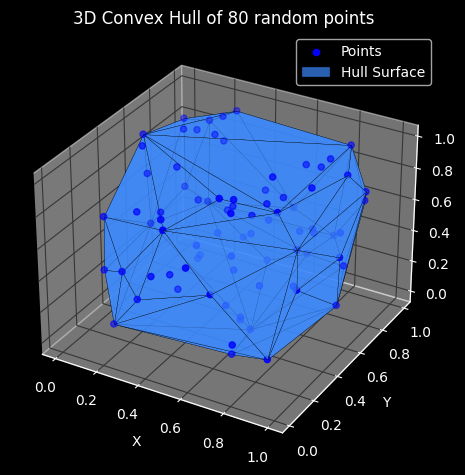

In [104]:
# Plot the 3D convex hull
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure()
ax = plt.axes(projection='3d')

fig.patch.set_facecolor('#000' if plots_theme == 'dark_background' else '#FFFFFF')

# Scatter the points
ax.scatter([p.x for p in dataset], [p.y for p in dataset], [p.z for p in dataset], color='blue', label='Points')

# Plot the points
for index, face in enumerate(result):
    vertices = [face.get_vertices()]
    if index == 0:
        poly = Poly3DCollection(
            vertices, alpha=0.7, 
            linewidths=0.2, 
            edgecolors='k', 
            facecolors='#3C8AFF', 
            label="Hull Surface"
        )
    else:
        poly = Poly3DCollection(
            vertices, alpha=0.7, 
            linewidths=0.2, 
            edgecolors='k', 
            facecolors='#3C8AFF', 
            label=''
        )
    ax.add_collection3d(poly)
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.xaxis._axinfo['grid'].update(color = grid_color)
ax.yaxis._axinfo['grid'].update(color = grid_color)
ax.zaxis._axinfo['grid'].update(color = grid_color)

ax.set_facecolor('black' if plots_theme == 'dark_background' else 'white')

plt.title(f'3D Convex Hull of {len(dataset)} random points')
plt.legend()
plt.tight_layout()
plt.show()

Από το παραπάνω διάγραμμα μπορούμε να διακρίνουμε πως το κυρτό περίβλημα των σημείων έχει όντως βρεθεί.